<a href="https://colab.research.google.com/github/potuu/Implementation_of_A_Domain_Generative_Graph_Network_for_EEG_Based_Emotion_Recognition/blob/main/1DCNNforEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPROCESSING

In [10]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
def process_eeg_directory(directory_path):
    """
    Processes all subject and experiment files in a directory, groups data by `user_id`,
    adds a unique ID based on the file name, and combines all grouped data into a single DataFrame.

    Args:
    - directory_path (str): Path to the directory containing EEG data files.

    Returns:
    - combined_data (pd.DataFrame): A single DataFrame containing all grouped data.
    """
    grouped_data = []

    # List all files in the directory
    file_list = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    # Loop through each file
    for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Check if `user_id` column exists
        if 'user_id' in df.columns:
            # Add a column to indicate the source file (unique ID for rows from this file)
            df['source_file'] = os.path.splitext(file_name)[0]  # File name without extension

            # Group by `user_id` and aggregate data into lists
            grouped = df.groupby('user_id').agg(list).reset_index()

            # Preserve the unique ID (source file) in the grouped data
            grouped['source_file'] = os.path.splitext(file_name)[0]

            # Append the grouped data to the list
            grouped_data.append(grouped)
        else:
            print(f"'user_id' column not found in file: {file_name}")

    # Combine all grouped data into a single DataFrame
    if grouped_data:
        combined_data = pd.concat(grouped_data, ignore_index=True)
        print("All files have been grouped by `user_id` and combined successfully.")
    else:
        combined_data = pd.DataFrame()
        print("No data was processed or combined.")

    return combined_data


# Example usage
directory_path = "/content/drive/MyDrive/eeg_database_kou/data_trail_csv"  # Replace with your actual directory path
combined_eeg_data = process_eeg_directory(directory_path)

# Save the combined data to a CSV file (optional)
combined_eeg_data.to_csv("grouped_combined_eeg_data.csv", index=False)

# Display a preview of the combined data
print("Combined EEG Data:")
print(combined_eeg_data.head())

All files have been grouped by `user_id` and combined successfully.
Combined EEG Data:
                                user_id  \
0  06f49575-a0ee-46fd-8d0d-4133886d62a5   
1  4737537c-0a5d-46e2-9c1f-9872520872c4   
2  4737537c-0a5d-46e2-9c1f-9872520872c4   
3  06f49575-a0ee-46fd-8d0d-4133886d62a5   
4  06f49575-a0ee-46fd-8d0d-4133886d62a5   

                                           Timestamp  \
0  [10:51:23 AM, 10:51:23 AM, 10:51:23 AM, 10:51:...   
1  [10:39:08 AM, 10:39:08 AM, 10:39:08 AM, 10:39:...   
2  [10:40:17 AM, 10:40:17 AM, 10:40:17 AM, 10:40:...   
3  [10:54:24 AM, 10:54:24 AM, 10:54:24 AM, 10:54:...   
4  [10:54:59 AM, 10:54:59 AM, 10:54:59 AM, 10:54:...   

                                             EEG.AF3  \
0  [3891.281982, 3895.384521, 3906.153809, 3900.0...   
1  [4017.435791, 4020.512939, 4015.384521, 4005.1...   
2  [4081.538574, 4083.589844, 4080.512939, 4074.3...   
3  [3981.025635, 3972.820557, 3965.641113, 3968.2...   
4  [3951.281982, 3953.846191, 3957.43

In [13]:
# Sort the DataFrame by `source_file` with proper numerical order
combined_eeg_data['source_file'] = combined_eeg_data['source_file'].str.split('_').map(lambda x: (int(x[0]), int(x[1])))
combined_eeg_data = combined_eeg_data.sort_values(by='source_file').reset_index(drop=True)

# Display sorted `source_file` column
print(combined_eeg_data['source_file'].head())

0    (1, 1)
1    (1, 2)
2    (1, 3)
3    (1, 4)
4    (1, 5)
Name: source_file, dtype: object


In [14]:
labels_data_path = "/content/drive/MyDrive/eeg_database_kou/label_processed_data.csv"
labels_data = pd.read_csv(labels_data_path)
split_columns = ["user_id", "trial", "start_date", "finish_date", "duration", "val", "aro", "dom"]
processed_labels_data = labels_data.iloc[:, 0].str.split(";", expand=True)
processed_labels_data.columns = split_columns

# Inspect the transformed data
print("Labels Preview:")
print(processed_labels_data.head())

# Check for missing values in label data
print("\nMissing Values in Label Data:")
print(processed_labels_data.isnull().sum())

Labels Preview:
                                user_id trial                  start_date  \
0  7a4efc4f-6def-4ba3-a56d-672aec0fe324     1  2023-10-11 12:45:06.863000   
1  7a4efc4f-6def-4ba3-a56d-672aec0fe324     2  2023-10-11 12:45:41.053000   
2  7a4efc4f-6def-4ba3-a56d-672aec0fe324     3  2023-10-11 12:46:15.225000   
3  7a4efc4f-6def-4ba3-a56d-672aec0fe324     4  2023-10-11 12:46:49.414000   
4  7a4efc4f-6def-4ba3-a56d-672aec0fe324     5  2023-10-11 12:47:33.596000   

                  finish_date duration val aro dom  
0  2023-10-11 12:45:35.888000       29   1   0   1  
1  2023-10-11 12:46:10.055000       29   0   1   1  
2  2023-10-11 12:46:44.240000       29   1   1   0  
3  2023-10-11 12:47:18.427000       29   0   1   1  
4  2023-10-11 12:48:02.605000       29   1   0   0  

Missing Values in Label Data:
user_id        0
trial          0
start_date     0
finish_date    0
duration       0
val            0
aro            0
dom            0
dtype: int64


In [15]:
import math

# Add the `source_file` column to processed_labels_data
processed_labels_data['source_file'] = processed_labels_data.apply(
    lambda row: (math.ceil((row.name + 1) / 20), int(row['trial'])),  # 20 trials per subject
    axis=1
)

# Inspect the updated DataFrame
print("Processed Labels with Source File:")
print(processed_labels_data.tail())


Processed Labels with Source File:
                                  user_id trial                  start_date  \
795  4737537c-0a5d-46e2-9c1f-9872520872c4    16  2023-12-14 10:37:49.814000   
796  4737537c-0a5d-46e2-9c1f-9872520872c4    17  2023-12-14 10:38:34.042000   
797  4737537c-0a5d-46e2-9c1f-9872520872c4    18  2023-12-14 10:39:08.306000   
798  4737537c-0a5d-46e2-9c1f-9872520872c4    19  2023-12-14 10:39:42.525000   
799  4737537c-0a5d-46e2-9c1f-9872520872c4    20  2023-12-14 10:40:16.724000   

                    finish_date duration val aro dom source_file  
795  2023-12-14 10:38:18.829000       29   0   1   1    (40, 16)  
796  2023-12-14 10:39:03.078000       29   1   1   1    (40, 17)  
797  2023-12-14 10:39:37.327000       29   0   1   1    (40, 18)  
798  2023-12-14 10:40:11.539000       29   1   1   1    (40, 19)  
799  2023-12-14 10:40:45.751000       29   0   1   1    (40, 20)  


In [16]:
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Bandpass Filter Function
def bandpass_filter(data, lowcut=1.0, highcut=50.0, fs=128.0, order=4):
    """
    Apply a bandpass filter to EEG data.

    Args:
    - data (ndarray): EEG data (timesteps x channels).
    - lowcut (float): Low cutoff frequency in Hz.
    - highcut (float): High cutoff frequency in Hz.
    - fs (float): Sampling frequency in Hz.
    - order (int): Filter order.

    Returns:
    - filtered_data (ndarray): Bandpass filtered EEG data.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Preprocess EEG Data without Labels
def preprocess_eeg_data(df, target_length=3712, lowcut=1.0, highcut=50.0, fs=128.0):
    """
    Preprocess EEG data by applying a bandpass filter and fixing the length.

    Args:
    - df (DataFrame): Raw EEG data DataFrame (columns are EEG channels).
    - target_length (int): Fixed length for time-series data.
    - lowcut (float): Low cutoff frequency for the filter.
    - highcut (float): High cutoff frequency for the filter.
    - fs (float): Sampling frequency.

    Returns:
    - data (ndarray): Preprocessed EEG data of shape (samples, timesteps, channels).
    """
    n_samples = len(df)
    n_channels = len(df.columns)  # Assuming all columns are EEG channels
    data = np.zeros((n_samples, target_length, n_channels))

    for i in range(n_samples):
        for j in range(n_channels):
            channel_data = df.iloc[i, j]
            if isinstance(channel_data, str):
                channel_data = eval(channel_data)  # Convert string to list

            # Apply bandpass filter
            channel_data = bandpass_filter(np.array(channel_data), lowcut, highcut, fs)

            # Adjust length
            if len(channel_data) < target_length:
                channel_data = np.pad(channel_data, (0, target_length - len(channel_data)), 'constant')
            else:
                channel_data = channel_data[:target_length]

            data[i, :, j] = channel_data

    return data

# Min-Max Scaling
def apply_min_max_scaling(data):
    """
    Apply Min-Max scaling to EEG data.

    Args:
    - data (ndarray): EEG data (samples x timesteps x channels).

    Returns:
    - scaled_data (ndarray): Scaled EEG data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    n_samples, n_timesteps, n_channels = data.shape
    scaled_data = np.zeros_like(data)

    # Scale each channel independently
    for ch in range(n_channels):
        reshaped_data = data[:, :, ch].reshape(-1, 1)  # Flatten for scaling
        scaled_channel = scaler.fit_transform(reshaped_data).reshape(n_samples, n_timesteps)
        scaled_data[:, :, ch] = scaled_channel

    return scaled_data

In [17]:
# Ensure 'source_file' is in tuple format for both DataFrames
combined_eeg_data['source_file'] = combined_eeg_data['source_file'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
processed_labels_data['source_file'] = processed_labels_data['source_file'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

# Merge combined_eeg_data with processed_labels_data based on 'source_file'
merged_data = combined_eeg_data.merge(
    processed_labels_data[['source_file', 'aro', 'val']],
    on='source_file',
    how='left'  # Use 'left' join to keep all rows from combined_eeg_data
)

# Inspect the resulting DataFrame
print("Merged Data (with Labels):")
print(merged_data.head())

# Save the merged DataFrame to a new CSV file (optional)
#merged_data.to_csv("merged_eeg_with_labels.csv", index=False)

Merged Data (with Labels):
                                user_id  \
0  7a4efc4f-6def-4ba3-a56d-672aec0fe324   
1  7a4efc4f-6def-4ba3-a56d-672aec0fe324   
2  7a4efc4f-6def-4ba3-a56d-672aec0fe324   
3  7a4efc4f-6def-4ba3-a56d-672aec0fe324   
4  7a4efc4f-6def-4ba3-a56d-672aec0fe324   

                                           Timestamp  \
0  [12:45:07 PM, 12:45:07 PM, 12:45:07 PM, 12:45:...   
1  [12:45:41 PM, 12:45:41 PM, 12:45:41 PM, 12:45:...   
2  [12:46:15 PM, 12:46:15 PM, 12:46:15 PM, 12:46:...   
3  [12:46:49 PM, 12:46:49 PM, 12:46:49 PM, 12:46:...   
4  [12:47:34 PM, 12:47:34 PM, 12:47:34 PM, 12:47:...   

                                             EEG.AF3  \
0  [4018.461426, 4014.871826, 4011.794922, 4010.2...   
1  [3984.615479, 3990.256348, 3988.205078, 3980.5...   
2  [3985.641113, 3987.692383, 3985.641113, 3985.6...   
3  [4014.358887, 4011.794922, 4015.897461, 4015.3...   
4  [3727.692383, 3735.384521, 3740.512939, 3735.3...   

                                        

In [31]:
num_user_ids = len(merged_data)

print(f"Number of samples: {num_user_ids}")

Number of samples: 800


In [32]:
merged_data.shape

(800, 19)

In [33]:
# EEG ile başlayan sütunları seçelim
eeg_columns = [col for col in merged_data.columns if col.startswith('EEG.')]

# EEG sütunlarındaki array'lerde kaç veri olduğunu yazdıralım
for col in eeg_columns:
    # Her bir sütundaki array'in boyutunu yazdırıyoruz
    print(f"{col}: {len(merged_data[col].iloc[0])} verisi var.")


EEG.AF3: 3708 verisi var.
EEG.F7: 3708 verisi var.
EEG.F3: 3708 verisi var.
EEG.FC5: 3708 verisi var.
EEG.T7: 3708 verisi var.
EEG.P7: 3708 verisi var.
EEG.O1: 3708 verisi var.
EEG.O2: 3708 verisi var.
EEG.P8: 3708 verisi var.
EEG.T8: 3708 verisi var.
EEG.FC6: 3708 verisi var.
EEG.F4: 3708 verisi var.
EEG.F8: 3708 verisi var.
EEG.AF4: 3708 verisi var.


In [34]:
# satır yapısını gözlemlemek adına rastgele 346. satırdaki verilere ulaşmak için
print(merged_data.iloc[345])


user_id                     9bbf02ef-b2a5-4956-8654-5de9eaa126c4
Timestamp      [02:59:30 PM, 02:59:30 PM, 02:59:30 PM, 02:59:...
EEG.AF3        [3986.153809, 3993.846191, 3996.923096, 3994.8...
EEG.F7         [4183.077148, 4192.820313, 4196.410156, 4187.1...
EEG.F3         [3783.589844, 3784.615479, 3785.641113, 3783.0...
EEG.FC5        [4107.692383, 4108.205078, 4121.538574, 4118.4...
EEG.T7         [4095.384521, 4093.846191, 4091.281982, 4091.7...
EEG.P7         [4158.461426, 4154.871582, 4152.820313, 4154.3...
EEG.O1         [4173.846191, 4169.743652, 4169.230957, 4170.2...
EEG.O2         [4122.05127, 4122.05127, 4113.846191, 4111.282...
EEG.P8         [3913.846191, 3920.512939, 3914.871826, 3907.1...
EEG.T8         [4504.615234, 4514.871582, 4515.897461, 4509.7...
EEG.FC6        [4480.512695, 4491.282227, 4494.358887, 4489.2...
EEG.F4         [4554.871582, 4562.563965, 4567.179688, 4562.5...
EEG.F8         [4076.410156, 4091.794922, 4097.94873, 4092.30...
EEG.AF4        [4523.5898

In [22]:
# İlk satırdaki EEG.F8 değerini almak
row_index = 0  # Hangi satırı kontrol etmek istiyorsanız o indeksi belirtin
f8_values = merged_data.loc[row_index, "EEG.F8"]

print(f8_values)


[4113.333496, 4106.666504, 4104.615234, 4111.794922, 4117.436035, 4116.922852, 4135.384766, 4177.436035, 4191.794922, 4173.846191, 4165.641113, 4172.307617, 4170.769043, 4160.512695, 4151.282227, 4134.358887, 4115.897461, 4114.358887, 4120.512695, 4110.769043, 4101.025879, 4108.717773, 4116.922852, 4114.871582, 4109.230957, 4104.102539, 4104.102539, 4106.153809, 4108.205078, 4114.358887, 4120.512695, 4121.025879, 4120.0, 4121.025879, 4117.94873, 4110.256348, 4106.666504, 4110.769043, 4110.256348, 4109.743652, 4115.384766, 4114.871582, 4105.641113, 4103.589844, 4108.205078, 4107.179688, 4105.641113, 4106.666504, 4105.128418, 4103.589844, 4103.589844, 4105.641113, 4108.717773, 4112.820313, 4110.769043, 4110.256348, 4112.307617, 4111.794922, 4110.769043, 4112.307617, 4114.358887, 4113.333496, 4111.282227, 4107.179688, 4102.563965, 4106.666504, 4123.589844, 4141.025879, 4148.205078, 4150.769043, 4155.897461, 4153.846191, 4140.512695, 4137.94873, 4149.743652, 4148.205078, 4142.563965, 4154.

In [23]:
# Veriyi temizleme
merged_data_cleaned = merged_data.dropna()  # Eksik verileri kaldırma


In [24]:
# user_id, Timestamp, source_file sütunlarını kaldırma
merged_data_cleaned = merged_data.drop(columns=['user_id', 'Timestamp', 'source_file'])

# Veriyi ekrana yazdırma
print(merged_data_cleaned.head())


                                             EEG.AF3  \
0  [4018.461426, 4014.871826, 4011.794922, 4010.2...   
1  [3984.615479, 3990.256348, 3988.205078, 3980.5...   
2  [3985.641113, 3987.692383, 3985.641113, 3985.6...   
3  [4014.358887, 4011.794922, 4015.897461, 4015.3...   
4  [3727.692383, 3735.384521, 3740.512939, 3735.3...   

                                              EEG.F7  \
0  [4269.230957, 4261.538574, 4252.820313, 4247.1...   
1  [4274.358887, 4278.974121, 4270.769043, 4263.5...   
2  [4320.512695, 4320.0, 4327.692383, 4338.974121...   
3  [4216.410156, 4220.0, 4234.871582, 4243.589844...   
4  [4250.769043, 4256.922852, 4252.820313, 4249.2...   

                                              EEG.F3  \
0  [3793.846191, 3794.358887, 3788.205078, 3785.1...   
1  [3747.692383, 3749.230713, 3746.666748, 3740.5...   
2  [3793.333252, 3796.923096, 3794.871826, 3794.8...   
3  [3769.230713, 3772.307617, 3775.897461, 3771.7...   
4  [3791.281982, 3800.0, 3805.641113, 3796.410

In [25]:
# 283. satırdaki verilere ulaşmak için
print(merged_data_cleaned.iloc[283])


EEG.AF3    [3981.538574, 3987.692383, 3994.358887, 3991.7...
EEG.F7     [4275.897461, 4282.05127, 4288.205078, 4286.15...
EEG.F3     [3772.820557, 3771.794922, 3770.769287, 3769.2...
EEG.FC5    [4145.128418, 4142.563965, 4143.077148, 4144.6...
EEG.T7     [4103.077148, 4098.974121, 4095.897461, 4092.8...
EEG.P7     [4214.358887, 4214.358887, 4218.974121, 4211.2...
EEG.O1     [4124.102539, 4132.820313, 4131.794922, 4122.0...
EEG.O2     [4109.743652, 4110.769043, 4111.282227, 4106.1...
EEG.P8     [3929.743652, 3924.615479, 3926.666748, 3933.8...
EEG.T8     [4559.487305, 4553.846191, 4569.230957, 4570.2...
EEG.FC6    [4478.974121, 4475.384766, 4477.436035, 4477.9...
EEG.F4     [4565.128418, 4565.128418, 4567.179688, 4561.5...
EEG.F8     [4104.615234, 4105.128418, 4108.205078, 4106.1...
EEG.AF4    [4583.077148, 4577.94873, 4575.897461, 4574.87...
aro                                                        1
val                                                        0
Name: 283, dtype: object

In [26]:
# merged_data veri çerçevesinin sütun isimlerini yazdırma
print("Sütun İsimleri:")
for column in merged_data.columns:
    print(column)


Sütun İsimleri:
user_id
Timestamp
EEG.AF3
EEG.F7
EEG.F3
EEG.FC5
EEG.T7
EEG.P7
EEG.O1
EEG.O2
EEG.P8
EEG.T8
EEG.FC6
EEG.F4
EEG.F8
EEG.AF4
source_file
aro
val


In [27]:
# EEG ile başlayan sütunları seçme
eeg_columns = [col for col in merged_data.columns if col.startswith('EEG.')]

# EEG sütunlarındaki array'lerde kaç veri olduğunu yazdırma
for col in eeg_columns:
    # Her bir sütundaki array'in boyutunu yazdırma
    print(f"{col}: {len(merged_data[col].iloc[0])} verisi var.")


EEG.AF3: 3708 verisi var.
EEG.F7: 3708 verisi var.
EEG.F3: 3708 verisi var.
EEG.FC5: 3708 verisi var.
EEG.T7: 3708 verisi var.
EEG.P7: 3708 verisi var.
EEG.O1: 3708 verisi var.
EEG.O2: 3708 verisi var.
EEG.P8: 3708 verisi var.
EEG.T8: 3708 verisi var.
EEG.FC6: 3708 verisi var.
EEG.F4: 3708 verisi var.
EEG.F8: 3708 verisi var.
EEG.AF4: 3708 verisi var.


In [28]:
# EEG ile başlayan sütunları seçme
eeg_columns = [col for col in merged_data.columns if col.startswith('EEG.')]

# EEG sütunlarındaki array'lerdeki uzunlukları kontrol etme
for col in eeg_columns:
    inconsistent_rows = []

    # Her bir satırdaki array'in uzunluğunu kontrol etme
    for index, row in merged_data.iterrows():
        if len(row[col]) != len(merged_data[col].iloc[0]):
            inconsistent_rows.append(index)

    # Eğer tutarsızlık varsa, bu satırları yazdırma
    if inconsistent_rows:
        print(f"Farklı uzunlukta array bulunan satırlar ({col} sütununda): {inconsistent_rows}")


Farklı uzunlukta array bulunan satırlar (EEG.AF3 sütununda): [2, 4, 5, 6, 9, 12, 13, 16, 22, 23, 24, 25, 28, 32, 33, 34, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 79, 85, 86, 87, 88, 89, 90, 91, 92, 99, 100, 101, 108, 109, 110, 111, 112, 119, 120, 121, 122, 123, 128, 129, 130, 131, 132, 133, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 180, 181, 184, 187, 188, 189, 190, 191, 192, 193, 194, 200, 201, 202, 203, 204, 205, 206, 216, 217, 218, 219, 220, 221, 222, 223, 225, 230, 231, 239, 242, 248, 249, 250, 251, 256, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 278, 279, 280, 281, 282, 283, 284, 292, 293, 294, 295, 296, 297, 298, 299, 300, 303, 304, 305, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 352, 353, 354, 355, 356, 357, 35

In [29]:
import numpy as np
from scipy.signal import butter, filtfilt
import pandas as pd

# Band-pass filtresi için butterworth filtresi oluşturma
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frekansı
    low = lowcut / nyquist  # Düşük frekans kesimi
    high = highcut / nyquist  # Yüksek frekans kesimi
    b, a = butter(order, [low, high], btype='band')

    if len(data) > order:  # Veri uzunluğunun filtreleme için yeterli olup olmadığını kontrol et
        filtered_data = filtfilt(b, a, data)
    else:
        filtered_data = data  # Eğer veri çok kısa ise, filtreleme yapmadan veriyi olduğu gibi bırak
    return filtered_data

# EEG verilerini band-pass filtre uygulamak
def filter_eeg_data(eeg_data, lowcut, highcut, fs):
    filtered_data = {}
    for column in eeg_data.columns:
        # Her bir EEG kanalındaki veriyi al (bu veri dizisi olarak alınmalıdır)
        data = eeg_data[column]  # EEG verisi zaten bir dizi olabilir
        # Her kanal için band-pass filtresi uygulama
        filtered_data[column] = data.apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))
    return pd.DataFrame(filtered_data)

# EEG verilerinin bulunduğu 'merged_data' veri çerçevesini 'user_id' ve 'Timestamp' hariç al
eeg_data = merged_data.drop(columns=['user_id', 'Timestamp', 'aro', 'val'])

# Verinin örnek parametreleri
lowcut = 1.0  # Düşük frekans (Hz)
highcut = 50.0  # Yüksek frekans (Hz)
fs = 250  # Örnekleme frekansı (Hz)

# Band-pass filtresini EEG verilerine uygulama
filtered_eeg_data = filter_eeg_data(eeg_data, lowcut, highcut, fs)

# 'aro' ve 'val' sütunlarını olduğu gibi bırakıyoruz ve filtresi yapılmış EEG verileriyle birleştiriyoruz
filtered_eeg_data['aro'] = merged_data['aro']
filtered_eeg_data['val'] = merged_data['val']



In [30]:
print(filtered_eeg_data.head())

                                             EEG.AF3  \
0  [3.822408254386287, -0.107609635535617, -2.136...   
1  [-4.684884249648351, -2.0445122131796603, -3.3...   
2  [-1.7145195955541543, -2.135729125035467, -0.8...   
3  [3.719529942264249, 3.8973080855562907, 4.0090...   
4  [-3.125178227921227, 3.013932457129723, 4.8534...   

                                              EEG.F7  \
0  [15.159046022015639, 8.153032011756563, 0.6569...   
1  [-0.6178966280137121, -1.3426158953502862, -3....   
2  [2.7197010893899307, 5.764214948801842, 11.241...   
3  [14.422464312746353, 23.385855481357922, 30.97...   
4  [-4.803572018680795, -2.416309726409969, -1.99...   

                                              EEG.F3  \
0  [5.382019274341784, 2.8269712691049156, 1.0699...   
1  [-2.3730615932454326, -2.2196447406221522, -4....   
2  [-2.025532518982459, -1.624470650652609, 0.195...   
3  [0.27144962352863555, 3.9617594432407564, 5.16...   
4  [2.666048738620909, 10.393312292786579, 12.

# Feature Selection

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

In [36]:
from sklearn.feature_selection import mutual_info_regression

# Karşılıklı bilgi hesaplamak için fonksiyon (regresyon)
def mutual_information(X, y):
    """
    Karşılıklı bilgi hesaplama fonksiyonu (regresyon için).
    X: Özellikler
    y: Sürekli etiketler (regresyon için)
    """
    return mutual_info_regression(X, y)

# DMIM özellik seçimi için örnek fonksiyon
def dmim_feature_selection(X, y):
    """
    DMIM temelli özellik seçimi.
    X: Özellik matrisi
    y: Etiketler (sürekli)
    """
    n_features = X.shape[1]
    feature_scores = np.zeros(n_features)

    # Her özelliği değerlendirme
    for i in range(n_features):
        feature = X[:, i]
        mi_with_class = mutual_information(feature.reshape(-1, 1), y)  # MI özelliği ve sınıf
        max_mi_with_other_features = np.max([mutual_information(feature.reshape(-1, 1), X[:, j]) for j in range(n_features) if j != i])
        max_mi_with_class_specific = np.max([mutual_information(feature.reshape(-1, 1), X[:, j]) for j in range(n_features)])

        # DMIM fonksiyonunu kullanarak her özelliği derecelendirme
        feature_scores[i] = mi_with_class - max_mi_with_other_features + max_mi_with_class_specific

    # En yüksek skora sahip özellikleri seçme (örneğin, en iyi 20)
    top_features_idx = np.argsort(feature_scores)[-20:]

    return top_features_idx, feature_scores

# Örnek EEG verisi (merged_data_cleaned)
X = np.random.rand(100, 50)  # 100 örnek ve 50 özellik (rastgele veriler)
y = np.random.rand(100)  # Sürekli etiketler (regresyon)

# DMIM ile özellik seçimi yapma
top_features, feature_scores = dmim_feature_selection(X, y)

# Seçilen en iyi 20 özelliği gösterme
print("En iyi 20 özellik:", top_features)
print("Özellik skorlari:", feature_scores[top_features])

# Özelliklerin sıralanmış hali
print("Tüm özellik sıralaması:", np.argsort(feature_scores)[::-1])


<ipython-input-36-7ae4fef85b75>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_scores[i] = mi_with_class - max_mi_with_other_features + max_mi_with_class_specific
<ipython-input-36-7ae4fef85b75>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_scores[i] = mi_with_class - max_mi_with_other_features + max_mi_with_class_specific
<ipython-input-36-7ae4fef85b75>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_scores[i] = mi_with_class - max

En iyi 20 özellik: [18 21 48 39 22 10  7 28  8 30 45 13 19 15 33 24 49 29 25  3]
Özellik skorlari: [3.20373796 3.20705975 3.20705975 3.20866592 3.2107693  3.21422501
 3.21746244 3.21971968 3.22064728 3.22064728 3.2271317  3.22721429
 3.22748163 3.24457868 3.24702821 3.25716412 3.27660096 3.29757917
 3.30653187 3.31250873]
Tüm özellik sıralaması: [ 3 25 29 49 24 33 15 19 13 45 30  8 28  7 10 22 39 48 21 18 17 14 42 34
 46 27 37 31  1 43 47 16 23  6 40  9 44 35 36  2 12 32 20  4 38 11 41  0
 26  5]


<ipython-input-36-7ae4fef85b75>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_scores[i] = mi_with_class - max_mi_with_other_features + max_mi_with_class_specific


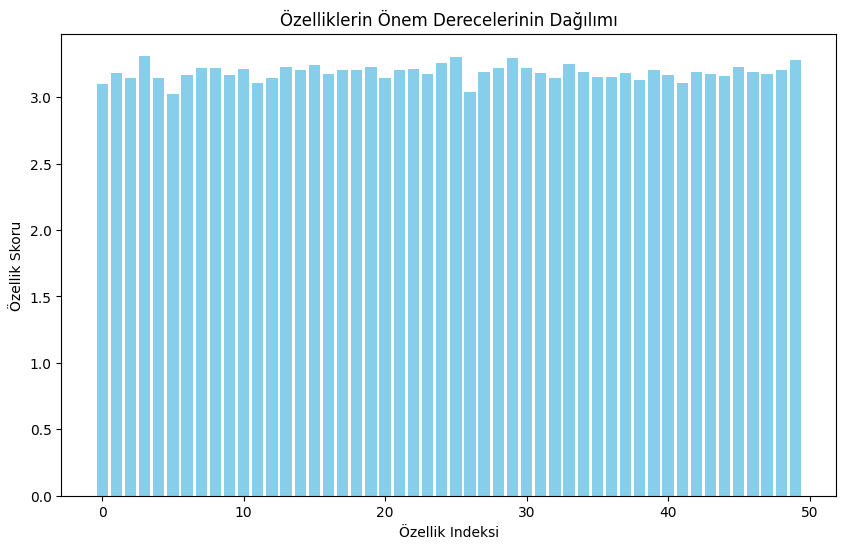

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Özellik skoru görselleştirme
def plot_feature_importance(feature_scores):
    """
    Özelliklerin önem derecelerini gösteren bar grafiği.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_scores)), feature_scores, color='skyblue')
    plt.xlabel('Özellik Indeksi')
    plt.ylabel('Özellik Skoru')
    plt.title('Özelliklerin Önem Derecelerinin Dağılımı')
    plt.show()

# Özelliklerin sıralanmış hali
plot_feature_importance(feature_scores)


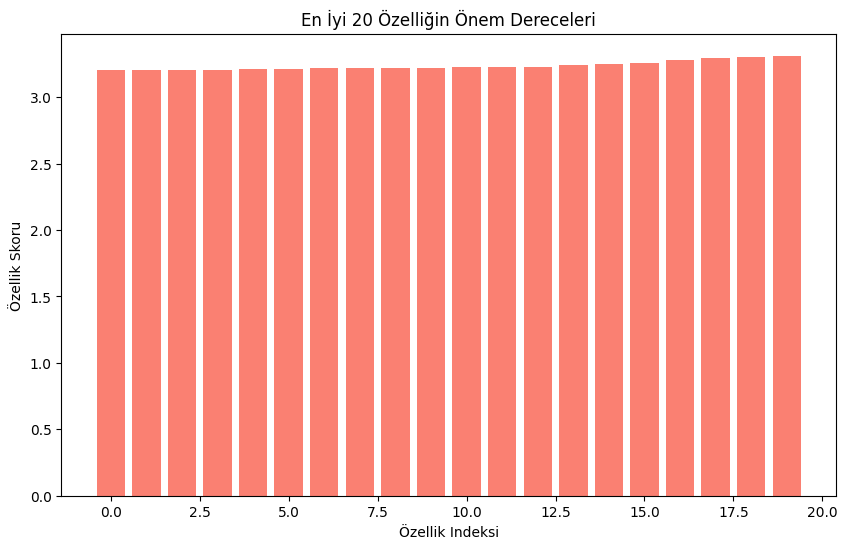

In [38]:
# En iyi 20 özelliğin görselleştirilmesi
def plot_top_features(top_features, feature_scores):
    """
    Seçilen en iyi 20 özelliğin önem derecelerini gösteren bar grafiği.
    """
    plt.figure(figsize=(10, 6))
    top_scores = feature_scores[top_features]
    plt.bar(range(len(top_features)), top_scores, color='salmon')
    plt.xlabel('Özellik Indeksi')
    plt.ylabel('Özellik Skoru')
    plt.title('En İyi 20 Özelliğin Önem Dereceleri')
    plt.show()

# Seçilen en iyi 20 özelliği görselleştirme
plot_top_features(top_features, feature_scores)


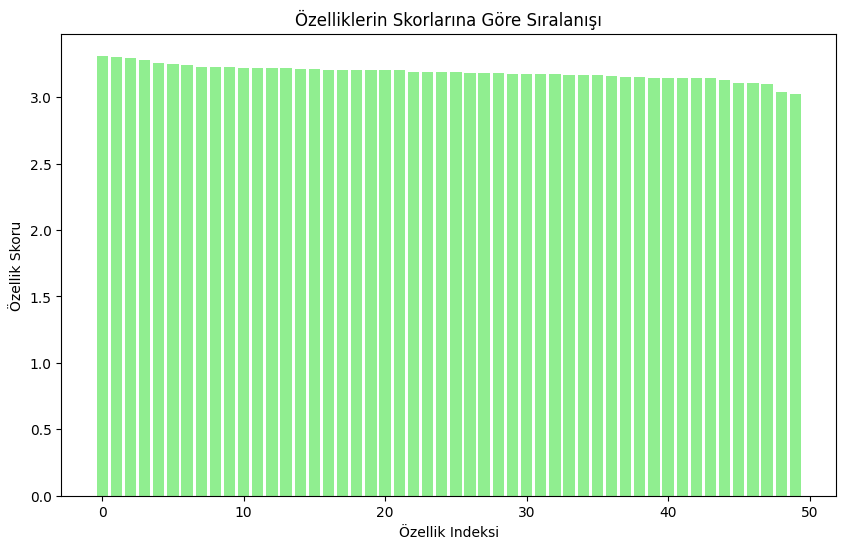

In [39]:
# Özelliklerin sıralanmış halini görselleştirme
def plot_sorted_feature_scores(feature_scores):
    """
    Özelliklerin sıralandığı bar grafiği.
    """
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_scores)[::-1]
    sorted_scores = feature_scores[sorted_idx]
    plt.bar(range(len(sorted_scores)), sorted_scores, color='lightgreen')
    plt.xlabel('Özellik Indeksi')
    plt.ylabel('Özellik Skoru')
    plt.title('Özelliklerin Skorlarına Göre Sıralanışı')
    plt.show()

# Özelliklerin sıralanmış hali
plot_sorted_feature_scores(feature_scores)


In [40]:
# filtered_eeg_data'nın yapısını kontrol etme
print(filtered_eeg_data.shape)


(800, 17)


# Model Eğitimi

## Binary Class

In [65]:
import numpy as np
import pandas as pd

# 1. EEG verisini al
# filtered_eeg_data, EEG verilerini içeren DataFrame'dir.
X = filtered_eeg_data.iloc[:, :14].values  # İlk 14 kanal (eeg.* sütunları)

# 2. Hedef verileri (aro ve val)
y = filtered_eeg_data[['aro', 'val']].values

# 3. Zaman serisi uzunluğunu eşitlemek için en uzun zaman serisini bulma
max_length = 0
for i in range(X.shape[0]):
    for col in range(X.shape[1]):
        value = X[i, col]

        # Eğer değeri string formatında alıyorsak, listeye dönüştürmek için eval kullanıyoruz
        if isinstance(value, str):
            time_series = np.array(eval(value))  # String formatındaki array'i alıyoruz
        elif isinstance(value, (np.ndarray, list)):
            time_series = np.array(value)  # Eğer zaten array veya listse, direkt alıyoruz
        else:
            raise ValueError(f"Beklenmeyen veri tipi: {type(value)}")

        # En uzun zaman serisini bulalım
        max_length = max(max_length, len(time_series))

# 4. Veriyi işleme ve zaman serisi uzunluklarını eşitleme
X_processed = []

for i in range(X.shape[0]):
    processed_data = []
    for col in range(X.shape[1]):
        value = X[i, col]

        if isinstance(value, str):
            time_series = np.array(eval(value))  # String formatındaki array'i alıyoruz
        elif isinstance(value, (np.ndarray, list)):
            time_series = np.array(value)  # Eğer zaten array veya listse, direkt alıyoruz
        else:
            raise ValueError(f"Beklenmeyen veri tipi: {type(value)}")

        # Eğer zaman serisinin uzunluğu max_length'ten kısa ise pad edelim
        if len(time_series) < max_length:
            time_series = np.pad(time_series, (0, max_length - len(time_series)), 'constant')

        # İşlenmiş veriyi listeye ekleme
        processed_data.append(time_series)

    # Tüm kanalları işledikten sonra örneği ekleme
    X_processed.append(np.array(processed_data))

# 5. Sonuçları numpy array'ine çevirme
X_processed = np.array(X_processed)

# 6. Şekil kontrolü
print("X_processed shape:", X_processed.shape)  # (800, 14, max_length)
print("y shape:", y.shape)  # (800, 2)


X_processed shape: (800, 14, 5116)
y shape: (800, 2)


In [66]:
from sklearn.model_selection import train_test_split

# Eğitim ve test verisi olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Verilerin şekline göz atma
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (640, 14, 5116), X_test shape: (160, 14, 5116)
y_train shape: (640, 2), y_test shape: (160, 2)


In [67]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler'i kanal bazında uygulama
scaler = MinMaxScaler()

# X_train ve X_test verilerini normalize edelim
X_train = X_train.reshape(-1, X_train.shape[-1])  # (800 * 14, max_length)
X_test = X_test.reshape(-1, X_test.shape[-1])    # (200 * 14, max_length)

# Normalizasyon
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Veriyi eski haline getirelim (reshape to 3D again)
X_train_scaled = X_train_scaled.reshape(-1, 14, 5116)
X_test_scaled = X_test_scaled.reshape(-1, 14, 5116)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


X_train_scaled shape: (640, 14, 5116)
X_test_scaled shape: (160, 14, 5116)


In [80]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Modeli başlat
model = Sequential()

# 1. Konvolüsyonel katman (64 filtre, 5x1 kernel)
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), padding='same'))
model.add(MaxPooling1D(pool_size=2))  # Pooling katmanı

# 2. Konvolüsyonel katman (32 filtre, 3x1 kernel)
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# 3. Konvolüsyonel katman (16 filtre, 3x1 kernel)
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))

# Flatten katmanı
model.add(Flatten())

# Dropout katmanı (overfitting'i engellemeye yardımcı olur)
model.add(Dropout(0.25))

# Tam bağlantı katmanı (Valence ve Arousal için 2 nöron)
model.add(Dense(2, activation='sigmoid'))

# Modeli derleyelim
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Modelin özetini alalım
model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_35 (Conv1D)                   │ (None, 14, 64)              │       1,637,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_36 (Conv1D)                   │ (None, 7, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 3, 16)               │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │              98 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,010 (6.28 MB)

 Trainable params: 1,645,010 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Model eğitimi
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_test_scaled, y_test))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.5337 - loss: 4.6361 - val_accuracy: 0.2500 - val_loss: 0.7976
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.6001 - loss: 0.7443 - val_accuracy: 0.7500 - val_loss: 0.7100
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.6380 - loss: 0.6869 - val_accuracy: 0.7437 - val_loss: 0.7123
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.6336 - loss: 0.6876 - val_accuracy: 0.7500 - val_loss: 0.7072
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.6210 - loss: 0.6875 - val_accuracy: 0.7500 - val_loss: 0.7036
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.6011 - loss: 0.6885 - val_accuracy: 0.7500 - val_loss: 0.7013
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.6178 - loss: 0.6857 - val_accuracy: 0.7500 - val_loss: 0.7016
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.6070 - loss: 0.6875 - val_accuracy: 0.

In [82]:
# Modelin performansını değerlendirme
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Valence için metrikler
valence_train_pred = y_train_pred[:, 0]
valence_test_pred = y_test_pred[:, 0]

valence_train_true = y_train[:, 0]
valence_test_true = y_test[:, 0]

# Eğitimdeki Valence sonuçları
valence_train_accuracy = np.mean(valence_train_true == np.round(valence_train_pred))
valence_train_loss = np.mean(np.abs(valence_train_true - valence_train_pred))

# Testteki Valence sonuçları
valence_test_accuracy = np.mean(valence_test_true == np.round(valence_test_pred))
valence_test_loss = np.mean(np.abs(valence_test_true - valence_test_pred))

# Precision, Recall, F1 Score
valence_train_precision = precision_score(valence_train_true, np.round(valence_train_pred))
valence_train_recall = recall_score(valence_train_true, np.round(valence_train_pred))
valence_train_f1 = f1_score(valence_train_true, np.round(valence_train_pred))

valence_test_precision = precision_score(valence_test_true, np.round(valence_test_pred))
valence_test_recall = recall_score(valence_test_true, np.round(valence_test_pred))
valence_test_f1 = f1_score(valence_test_true, np.round(valence_test_pred))

# Arousal için metrikler
arousal_train_pred = y_train_pred[:, 1]
arousal_test_pred = y_test_pred[:, 1]

arousal_train_true = y_train[:, 1]
arousal_test_true = y_test[:, 1]

# Eğitimdeki Arousal sonuçları
arousal_train_accuracy = np.mean(arousal_train_true == np.round(arousal_train_pred))
arousal_train_loss = np.mean(np.abs(arousal_train_true - arousal_train_pred))

# Testteki Arousal sonuçları
arousal_test_accuracy = np.mean(arousal_test_true == np.round(arousal_test_pred))
arousal_test_loss = np.mean(np.abs(arousal_test_true - arousal_test_pred))

# Precision, Recall, F1 Score
arousal_train_precision = precision_score(arousal_train_true, np.round(arousal_train_pred))
arousal_train_recall = recall_score(arousal_train_true, np.round(arousal_train_pred))
arousal_train_f1 = f1_score(arousal_train_true, np.round(arousal_train_pred))

arousal_test_precision = precision_score(arousal_test_true, np.round(arousal_test_pred))
arousal_test_recall = recall_score(arousal_test_true, np.round(arousal_test_pred))
arousal_test_f1 = f1_score(arousal_test_true, np.round(arousal_test_pred))

# Sonuçları yazdıralım
print(f"Valence - Train Accuracy: {valence_train_accuracy}")
print(f"Valence - Train Loss: {valence_train_loss}")
print(f"Valence - Test Accuracy: {valence_test_accuracy}")
print(f"Valence - Test Loss: {valence_test_loss}")
print(f"Valence - Train Precision: {valence_train_precision}")
print(f"Valence - Train Recall: {valence_train_recall}")
print(f"Valence - Train F1 Score: {valence_train_f1}")
print(f"Valence - Test Precision: {valence_test_precision}")
print(f"Valence - Test Recall: {valence_test_recall}")
print(f"Valence - Test F1 Score: {valence_test_f1}")

print("\n")

print(f"Arousal - Train Accuracy: {arousal_train_accuracy}")
print(f"Arousal - Train Loss: {arousal_train_loss}")
print(f"Arousal - Test Accuracy: {arousal_test_accuracy}")
print(f"Arousal - Test Loss: {arousal_test_loss}")
print(f"Arousal - Train Precision: {arousal_train_precision}")
print(f"Arousal - Train Recall: {arousal_train_recall}")
print(f"Arousal - Train F1 Score: {arousal_train_f1}")
print(f"Arousal - Test Precision: {arousal_test_precision}")
print(f"Arousal - Test Recall: {arousal_test_recall}")
print(f"Arousal - Test F1 Score: {arousal_test_f1}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Valence - Train Accuracy: 0.5890625
Valence - Train Loss: 0.4874662322923541
Valence - Test Accuracy: 0.59375
Valence - Test Loss: 0.48871956588700416
Valence - Train Precision: 0.5890625
Valence - Train Recall: 1.0
Valence - Train F1 Score: 0.7413962635201573
Valence - Test Precision: 0.5974842767295597
Valence - Test Recall: 0.9895833333333334
Valence - Test F1 Score: 0.7450980392156863


Arousal - Train Accuracy: 0.525
Arousal - Train Loss: 0.49882282316684723
Arousal - Test Accuracy: 0.55625
Arousal - Test Loss: 0.49865400455892084
Arousal - Train Precision: 0.525
Arousal - Train Recall: 1.0
Arousal - Train F1 Score: 0.6885245901639344
Arousal - Test Precision: 0.559748427672956
Arousal - Test Recall: 0.9888888888888889
Arousal - Test F1 Score: 0.714859437751004


## Multiclass Model

In [48]:
# EEG verilerini (sadece EEG sütunlarını) al
eeg_columns = [col for col in filtered_eeg_data.columns if col.startswith('EEG')]

# EEG verilerini ve sınıf hedeflerini ayır
X = filtered_eeg_data[eeg_columns].values  # Girdi verisi (EEG verileri)
y = filtered_eeg_data[['aro_class', 'val_class']].values  # Hedef sınıflar (aro_class ve val_class)

# Veriyi eğitim ve test setlerine ayır
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
# EEG verilerini alıyoruz, sadece "EEG." ile başlayan sütunları seçiyoruz
eeg_columns = [col for col in filtered_eeg_data.columns if col.startswith('EEG.')]

# EEG verilerinin her bir kanalındaki verilerin uzunluğunu kontrol edelim
for column in eeg_columns:
    eeg_data_column = filtered_eeg_data[column]
    lengths = [len(val) if isinstance(val, list) else 1 for val in eeg_data_column]
    print(f"{column} - Ortalama Uzunluk: {np.mean(lengths)} | Min Uzunluk: {np.min(lengths)} | Max Uzunluk: {np.max(lengths)}")


EEG.AF3 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.F7 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.F3 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.FC5 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.T7 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.P7 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.O1 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.O2 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.P8 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.T8 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.FC6 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.F4 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.F8 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1
EEG.AF4 - Ortalama Uzunluk: 1.0 | Min Uzunluk: 1 | Max Uzunluk: 1


In [68]:
# Veriyi dolduracak olan işlevi yazıyoruz
def pad_sequence(val, target_length):
    # Eğer veri uzunluğu target_length'ten kısa ise, pad yapıyoruz
    if isinstance(val, list):
        return val + [0] * (target_length - len(val))  # Pad işlemi
    return [0] * target_length  # Eğer veri list değilse, 0 ile dolduruyoruz

# Tüm EEG verilerini en uzun veri uzunluğuna kadar pad edelim
X = []

for column in eeg_columns:
    eeg_data_column = filtered_eeg_data[column]

    # Verileri pad edip düzleştiriyoruz
    padded_column_data = np.array([pad_sequence(val, max_length) for val in eeg_data_column])
    X.append(padded_column_data)

# X'i 2D bir diziye dönüştürüp kontrol edelim
X = np.array(X).T  # Verileri transpoze ediyoruz ki her satırda bir EEG kanalının verisi olsun

print(f"Veri boyutu: {X.shape}")


Veri boyutu: (1, 800, 14)


In [71]:
# 3D veriyi 2D'ye dönüştürmek: Bu adımda her bir EEG kanalını 2D hale getiriyoruz.
X_2d = X.reshape(-1, X.shape[-1])  # 2D'ye çeviriyoruz (tüm örnekler ve tüm kanallar)
print(f"2D veri boyutu: {X_2d.shape}")

# Veriyi normalleştirme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_2d)

print(f"Normalleştirilmiş veri boyutu: {X_scaled.shape}")



2D veri boyutu: (800, 14)
Normalleştirilmiş veri boyutu: (800, 14)


In [72]:
from sklearn.model_selection import train_test_split

# Hedef değişkeni (örneğin 'val' veya 'aro') belirleyin
y = filtered_eeg_data['val']  # Örneğin 'val' hedef değişkeni

# Eğitim ve test verisine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Eğitim verisi boyutu: {X_train.shape}")
print(f"Test verisi boyutu: {X_test.shape}")


Eğitim verisi boyutu: (640, 14)
Test verisi boyutu: (160, 14)


In [78]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Veriyi normalize etmeden önce özellikleri 1D formatına getirme
def pad_sequence(val, target_length):
    # Eğer veri uzunluğu target_length'ten kısa ise, pad yapıyoruz
    if isinstance(val, list):
        return val + [0] * (target_length - len(val))  # Pad işlemi
    return [0] * target_length  # Eğer veri list değilse, 0 ile dolduruyoruz

# EEG veri boyutlarını belirliyoruz
max_length = max([len(val) for val in filtered_eeg_data['EEG.AF3']])  # 'EEG.AF3' örnek olarak alındı, başka bir sütun da olabilir.

# Veriyi pad ederek 1D formatına getirme
X = []

# EEG sütunlarını kullanarak her bir kanalın verisini işleme
for column in eeg_columns:
    eeg_data_column = filtered_eeg_data[column]  # Filtrelenmiş EEG verisi

    # Her bir veriyi pad ediyoruz
    padded_column_data = np.array([pad_sequence(val, max_length) for val in eeg_data_column])
    X.append(padded_column_data)

# X'i 2D bir diziye dönüştürüp kontrol etme
X = np.array(X).T  # Her satırda bir EEG kanalının verisi olsun

# Normalleştirme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)  # 1D-CNN için uygun formatta normalleştiriyoruz

print(f"Normalleştirilmiş veri boyutu: {X_scaled.shape}")


Normalleştirilmiş veri boyutu: (5116, 800, 14)


In [84]:
# X_scaled'i (örnek sayısı, zaman adımları * kanal sayısı) formatına dönüştür
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], -1)

# Verilerin boyutlarını kontrol etme
print(f"X_scaled_reshaped shape: {X_scaled_reshaped.shape}")


X_scaled_reshaped shape: (5116, 11200)


In [85]:
# y boyutunu kontrol etme
print(f"y shape: {y.shape}")


y shape: (800, 2)


In [86]:
# Eğitim ve test setlerine ayırmadan önce, örnekleri uyumlu hale getirelim
import numpy as np

# Verilerdeki örnek sayısını kontrol edelim
num_samples = X_scaled.shape[0]
target_samples = y.shape[0]

# Eğer X'deki örnek sayısı, y'deki örnek sayısına uymuyorsa, uyumlu hale getirelim
# Bu durumda X'in örnek sayısını y'nin boyutuna uyarlayacağız
X_scaled_resized = X_scaled[:target_samples]

# Yeni boyutları kontrol edelim
print(f"Yeni X boyutu: {X_scaled_resized.shape}")
print(f"Yeni y boyutu: {y.shape}")


Yeni X boyutu: (800, 800, 14)
Yeni y boyutu: (800, 2)


In [87]:
from sklearn.model_selection import train_test_split

# Eğitim ve test setlerine ayıralım
X_train, X_test, y_train, y_test = train_test_split(X_scaled_resized, y, test_size=0.2, random_state=42)

# Verilerin boyutlarını kontrol edelim
print(f"X_train boyutu: {X_train.shape}")
print(f"X_test boyutu: {X_test.shape}")
print(f"y_train boyutu: {y_train.shape}")
print(f"y_test boyutu: {y_test.shape}")


X_train boyutu: (640, 800, 14)
X_test boyutu: (160, 800, 14)
y_train boyutu: (640, 2)
y_test boyutu: (160, 2)


In [88]:
from tensorflow.keras import layers, models

# Modeli oluşturma
model = models.Sequential()

# İlk 1D Conv katmanı
model.add(layers.Conv1D(64, 5, activation='relu', input_shape=(800, 14)))  # (zaman_adımı, kanal_sayısı)
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.25))

# İkinci 1D Conv katmanı
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.25))

# Üçüncü 1D Conv katmanı
model.add(layers.Conv1D(16, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.25))

# Veriyi düzleştirme (flatten)
model.add(layers.Flatten())

# Tam bağlantılı katman
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

# Çıktı katmanı - valence ve arousal için 2 ayrı çıktı
model.add(layers.Dense(2, activation='sigmoid'))  # Çift sınıflı çıktı (valence ve arousal)

# Modelin derlenmesi
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modelin özeti
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 796, 64)             │           4,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 796, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 398, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 398, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 394, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 394, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 197, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 197, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 195, 16)             │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 195, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 97, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 97, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1552)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          99,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,338 (454.45 KB)

 Trainable params: 116,114 (453.57 KB)

 Non-trainable params: 224 (896.00 B)

In [90]:
# Modeli eğitiyoruz
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.3386 - loss: 0.6875 - val_accuracy: 0.2812 - val_loss: 0.6860
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.3323 - loss: 0.6856 - val_accuracy: 0.2812 - val_loss: 0.6855
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.3045 - loss: 0.6858 - val_accuracy: 0.2812 - val_loss: 0.6852
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.3116 - loss: 0.6883 - val_accuracy: 0.2812 - val_loss: 0.6850
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.3174 - loss: 0.6878 - val_accuracy: 0.2812 - val_loss: 0.6846
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.3286 - loss: 0.6859 - val_accuracy: 0.2812 - val_loss: 0.6843
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3081 - loss: 0.6867 - val_accuracy: 0.2812 - val_loss: 0.6840
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.3315 - loss: 0.6853 - val_accuracy: 0.

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model tahminleri
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Valence ve Arousal tahminlerini kategorik hale getirme (eşik = 0.5)
valence_train_pred = np.round(y_train_pred[:, 0])
valence_test_pred = np.round(y_test_pred[:, 0])
valence_train_true = y_train[:, 0]
valence_test_true = y_test[:, 0]

arousal_train_pred = np.round(y_train_pred[:, 1])
arousal_test_pred = np.round(y_test_pred[:, 1])
arousal_train_true = y_train[:, 1]
arousal_test_true = y_test[:, 1]

# Valence metrikleri
valence_train_accuracy = accuracy_score(valence_train_true, valence_train_pred)
valence_test_accuracy = accuracy_score(valence_test_true, valence_test_pred)
valence_train_precision = precision_score(valence_train_true, valence_train_pred)
valence_train_recall = recall_score(valence_train_true, valence_train_pred)
valence_train_f1 = f1_score(valence_train_true, valence_train_pred)
valence_test_precision = precision_score(valence_test_true, valence_test_pred)
valence_test_recall = recall_score(valence_test_true, valence_test_pred)
valence_test_f1 = f1_score(valence_test_true, valence_test_pred)

# Arousal metrikleri
arousal_train_accuracy = accuracy_score(arousal_train_true, arousal_train_pred)
arousal_test_accuracy = accuracy_score(arousal_test_true, arousal_test_pred)
arousal_train_precision = precision_score(arousal_train_true, arousal_train_pred)
arousal_train_recall = recall_score(arousal_train_true, arousal_train_pred)
arousal_train_f1 = f1_score(arousal_train_true, arousal_train_pred)
arousal_test_precision = precision_score(arousal_test_true, arousal_test_pred)
arousal_test_recall = recall_score(arousal_test_true, arousal_test_pred)
arousal_test_f1 = f1_score(arousal_test_true, arousal_test_pred)

# Sonuçları yazdırma
print(f"Valence - Train Accuracy: {valence_train_accuracy}")
print(f"Valence - Train Loss: {np.mean(np.abs(valence_train_true - valence_train_pred))}")
print(f"Valence - Test Accuracy: {valence_test_accuracy}")
print(f"Valence - Test Loss: {np.mean(np.abs(valence_test_true - valence_test_pred))}")
print(f"Valence - Train Precision: {valence_train_precision}")
print(f"Valence - Train Recall: {valence_train_recall}")
print(f"Valence - Train F1 Score: {valence_train_f1}")
print(f"Valence - Test Precision: {valence_test_precision}")
print(f"Valence - Test Recall: {valence_test_recall}")
print(f"Valence - Test F1 Score: {valence_test_f1}")
print("\n")
print(f"Arousal - Train Accuracy: {arousal_train_accuracy}")
print(f"Arousal - Train Loss: {np.mean(np.abs(arousal_train_true - arousal_train_pred))}")
print(f"Arousal - Test Accuracy: {arousal_test_accuracy}")
print(f"Arousal - Test Loss: {np.mean(np.abs(arousal_test_true - arousal_test_pred))}")
print(f"Arousal - Train Precision: {arousal_train_precision}")
print(f"Arousal - Train Recall: {arousal_train_recall}")
print(f"Arousal - Train F1 Score: {arousal_train_f1}")
print(f"Arousal - Test Precision: {arousal_test_precision}")
print(f"Arousal - Test Recall: {arousal_test_recall}")
print(f"Arousal - Test F1 Score: {arousal_test_f1}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Valence - Train Accuracy: 0.525
Valence - Train Loss: 0.475
Valence - Test Accuracy: 0.5625
Valence - Test Loss: 0.4375
Valence - Train Precision: 0.525
Valence - Train Recall: 1.0
Valence - Train F1 Score: 0.6885245901639344
Valence - Test Precision: 0.5625
Valence - Test Recall: 1.0
Valence - Test F1 Score: 0.72


Arousal - Train Accuracy: 0.5890625
Arousal - Train Loss: 0.4109375
Arousal - Test Accuracy: 0.6
Arousal - Test Loss: 0.4
Arousal - Train Precision: 0.5890625
Arousal - Train Recall: 1.0
Arousal - Train F1 Score: 0.7413962635201573
Arousal - Test Precision: 0.6
Arousal - Test Recall: 1.0
Arousal - Test F1 Score: 0.75
